In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [2]:
from sklearn.neighbors import KNeighborsClassifier

#8 É o valor descoberto no TP2, continuando o mesmo modelo anterior
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Holdout
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

# Utilizar Validação cruzada com 5 folds que é o número mais comum para esse tipo de avaliação
scores_knn = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='f1')

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Novo algoritmo introduzido, random forest para entrar em comparação com o KNN
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Holdout
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Validação cruzada novamente
scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')

In [8]:
from sklearn.model_selection import GridSearchCV

# Definir os hiperparâmetros para o treinamento do Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

# GridSearchCV com validação cruzada
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Ajustar usando dados de treino
grid_rf.fit(X_train, y_train)

# Melhor modelo após CV
best_rf = grid_rf.best_estimator_
print(best_rf)

# Re-treinar e avaliar no teste
y_pred_rf_best = best_rf.predict(X_test)

acc_rf_best = accuracy_score(y_test, y_pred_rf_best)
prec_rf_best = precision_score(y_test, y_pred_rf_best)
rec_rf_best = recall_score(y_test, y_pred_rf_best)
f1_rf_best = f1_score(y_test, y_pred_rf_best)

RandomForestClassifier(n_estimators=200, random_state=42)


In [5]:
# Modelo Random Forest base ( sem hiperparâmetros )
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')

# Resultados
results = pd.DataFrame({
    "Modelo": ["KNN", "Random Forest", "Random Forest (tuned)"],
    "Acurácia": [acc_knn, acc_rf, acc_rf_best],
    "Precisão": [prec_knn, prec_rf, prec_rf_best],
    "Recall": [rec_knn, rec_rf, rec_rf_best],
    "F1-score": [f1_knn, f1_rf, f1_rf_best],
    "F1 (CV Média)": [scores_knn.mean(), scores_rf.mean(), grid_rf.best_score_]
})
print(results)

                  Modelo  Acurácia  Precisão    Recall  F1-score  \
0                    KNN   0.95614  0.958904  0.972222  0.965517   
1          Random Forest   0.95614  0.958904  0.972222  0.965517   
2  Random Forest (tuned)   0.95614  0.958904  0.972222  0.965517   

   F1 (CV Média)  
0       0.974092  
1       0.963408  
2       0.968444  


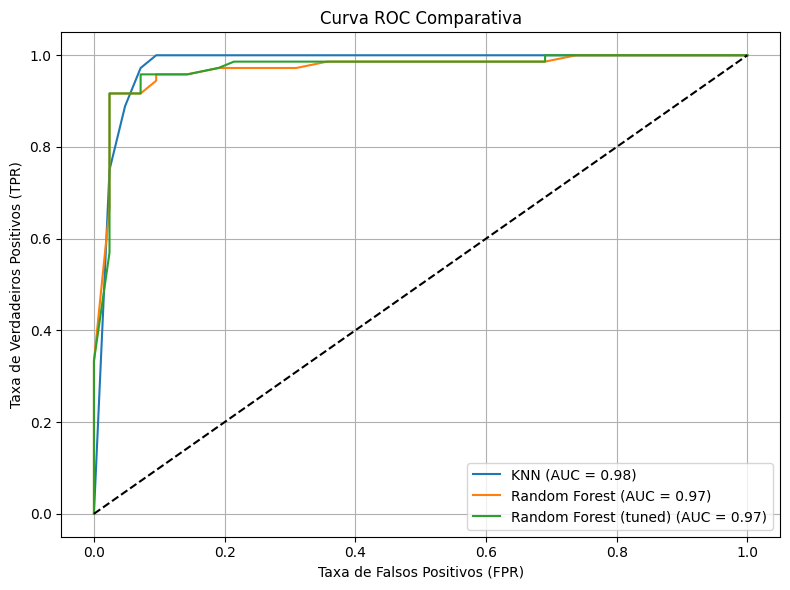

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

rf_best = grid_rf.best_estimator_

y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_prob_rf_best = rf_best.predict_proba(X_test_scaled)[:, 1]

# Calcular curvas ROC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_rf_best, tpr_rf_best, _ = roc_curve(y_test, y_prob_rf_best)

# Calcular AUC
auc_knn = auc(fpr_knn, tpr_knn)
auc_rf = auc(fpr_rf, tpr_rf)
auc_rf_best = auc(fpr_rf_best, tpr_rf_best)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_rf_best, tpr_rf_best, label=f'Random Forest (tuned) (AUC = {auc_rf_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC Comparativa')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Neste trabalho foram testado três modelos, o original KNN 8 que foi visto como o melhor modelo do TP2, o random forest (sem alteração), e o random forest ajustado com hiperparâmetros. A métrica usada na classificação, acurácia, precisão, recall, f1-score e principalmente AUC, nos mostram o desempenho de cada modelo, todos foram avaliados no final para saber qual teve o melhor desempenho.

A tabela final obtida foi essa:

| Modelo                | Acurácia | Precisão | Recall  | F1-score | F1 (CV Média) |
| --------------------- | -------- | -------- | ------- | -------- | ------------- |
| KNN                   | 0.95614  | 0.95890  | 0.97222 | 0.96551  | 0.97409       |
| Random Forest         | 0.95614  | 0.95890  | 0.97222 | 0.96551  | 0.96341       |
| Random Forest (hiper) | 0.95614  | 0.95890  | 0.97222 | 0.96551  | 0.96844       |

De acordo com os resultados podemos começar a interpretar.

A acurácia dos modelos mostram resultados similares, então o modelo em si não é importante nesse aspecto. Já em precisão e recall vemos dados idênticos, ambos esses dados servem para averiguar as taxas de acerto de um modelo, comparando o resultado e o previsto, sendo o f1 a harmonia dos dois resultados de precisão e recall, que também se mantém estático.

Agora no resultado final vemos uma maior diferença, também chamadop de AUC, vemos que o KNN se destaca com uma precisão maior do que modelos mais complexos que ele, além disso também vemos que o Random Forest que teve seus parâmetros re-treinados por hiperparâmetros, teve um aumento em seu score. Com isso o que podemos aprender?

Que o modelo escolhido ainda é o KNN, apesar de ser mais simples é visível que esse modelo de dados, é mais simples de previsões, todos as 3 formas de treinar o ml chegaram em resultados extremamente parecidos, e nas poucas diferenças que tiveram o KNN se destacou, portanto é o escolhido para essa situação.

Uma forma mais visível de suas diferenças é no gráfico de ROC que o KNN começa a performar melhor com uma menor seleção de dados, enquanto os outros precisam de mais falsos positivos para performar bem.